This exercise includes five parts:
1. Gaussian filtering
2. Fourier transform
3. Image derivatives
4. Edge detection
5. Hough transform

**Important:** 
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.
1. Do not remove or modify any given cells, except those in which you need to fill in your implementation. You can add cells in order to present additional texts or plots.
2. Restart the kernel and re-run the whole notebook once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
3. Submit only the `.ipynb` file, and do not change the file name.

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h1:before {counter-increment: section;
           content: counter(section, number) ". ";}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import scipy.signal
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import imageio

# Gaussian filtering
In the following, you will implement a method which generates and applies a Gaussian filter for a given variance and number of samples.

In [3]:
# Some convenience functions.

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

Start by writing a function ``gauss`` which creates a 1D Gaussian from a given vector of integer indices $\mathtt{x = [-w, \ldots, w]}$:
$$
    \mathtt{G[i]} = \frac{1}{\sqrt{2\pi}\sigma}\operatorname{exp}\biggl(-\frac{\mathtt{x[i]}^2}{2\sigma^2}\biggr)
$$
where $\sigma$ is the standard deviation.

Tip: In NumPy the best practice is to use functions on entire arrays at once, instead of iterating over items one by one. This makes the code easier to understand and also faster (since the actual loop is implemented in C under the hood).

In [4]:
# POINTS: 1

def gauss(x, sigma):
    x_sq = np.square(x)
    G = (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-x_sq/(2*sigma*sigma))
    return G
    raise NotImplementedError()

<IPython.core.display.Javascript object>


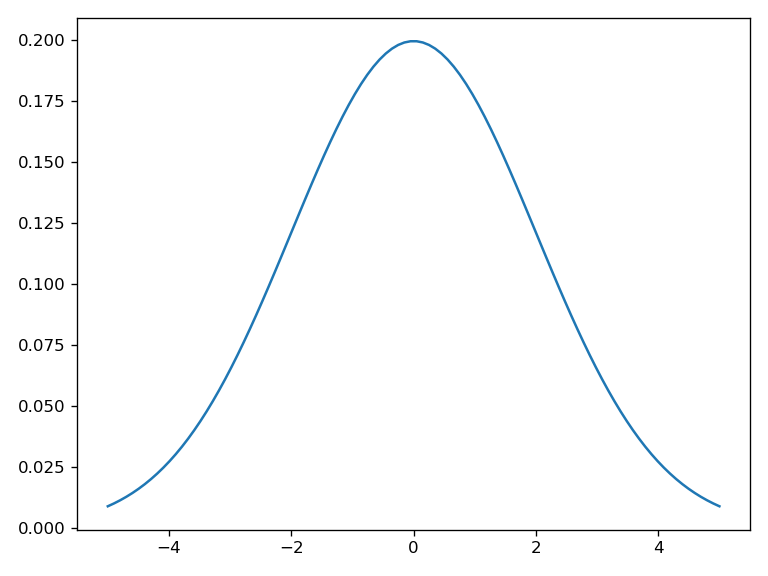

Gauss of 5 is 0.00876415024678427


In [5]:
x = np.linspace(-5, 5, 100)
y = gauss(x, sigma=2)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

print("Gauss of 5 is", gauss(5, sigma=2))

Use the above function to implement a function `gaussian_filter(image, sigma, padding)`, which first generates a Gaussian filter and then applies it to the `image`.
The size of the filter should be $2 \cdot \lceil 3 \sigma \rceil + 1$.
Remember that the Gaussian is separable, *i.e.* that an equivalent 2D result can be obtained through a sequence of two 1D filtering operations.
Do not use any existing implementation for convolution in this part (e.g. `scipy.ndimage.convolve`).
However, you are allowed to use these implementations in the following questions.

In [6]:
# POINTS: 5

def gaussian_filter(image, sigma, padding=True):
    
    #Extract input image size
    img_row_size , img_col_size , img_layer_size = image.shape
        
    #generation of the gaussian row and column filter
    fil_size = (2*3*sigma)+1
    x = np.linspace((-3*sigma) , (3*sigma) , num = fil_size)
    #x = np.linspace(-1 , 1 , num = fil_size)
    gauss_x_val = gauss(x, sigma)
    gauss_x = gauss_x_val[::-1] 
    gauss_y = gauss_x
    
    #image padding
    pad_size = int((fil_size-1)/2)
    img_padded = np.zeros(shape = ((img_row_size + (2*pad_size)),(img_col_size + (2*pad_size)),img_layer_size ))

    for layer_index in range(0,img_layer_size):

        img_padded[:,:,layer_index] = np.pad(image[:,:,1] , pad_width = pad_size)

    #extract padded image size   
    img_row_size_pad , img_col_size_pad , img_layer_size_pad = img_padded.shape
    
    #initialize output image
    img_x_conv = np.zeros(shape = (img_row_size_pad, img_col_size , img_layer_size))
    
    #row convolution along x for all image layers
    for layer_index in range(0,img_layer_size):
        for row_index in range(0,img_row_size_pad):
            for col_index in range(0, (img_col_size_pad - fil_size+1)):
                
                img_x_conv[row_index,col_index,layer_index] = np.sum(np.multiply(gauss_x, img_padded[row_index,col_index:col_index+fil_size ,layer_index]))     
    
    #row convolution along y
    image_result = np.zeros(shape = image.shape) #initialize final output image
    
    for layer_index in range(0,img_layer_size):
        for col_index in range(0,img_col_size):
            for row_index in range(0,(img_row_size_pad -fil_size+1)):
                
                image_result[row_index, col_index, layer_index] = np.sum(np.multiply( gauss_y , img_x_conv[row_index:row_index +fil_size, col_index, layer_index]))
      
    
   # image_result = np.array(image_result , np.int32)
    image_result = image_result.astype('float32')

#################################################### TEST#####################################################
    #Print Parameters
#     print("Input Image Size = " , image.shape)
#     print("Filter SD = ", sigma)
#     print('Pad_size = ', pad_size)
#     print("Padded Image Size = ", img_padded.shape)
#     print("Output Image Size After X Convolution =" , img_x_conv.shape)
#     print("Final Image Size After Y Convolution =", image_result.shape)
    #raise NotImplementedError()
    return image_result

<IPython.core.display.Javascript object>


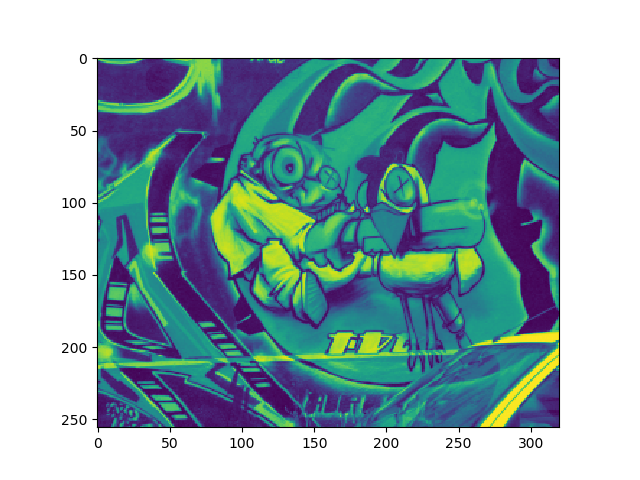

<IPython.core.display.Javascript object>


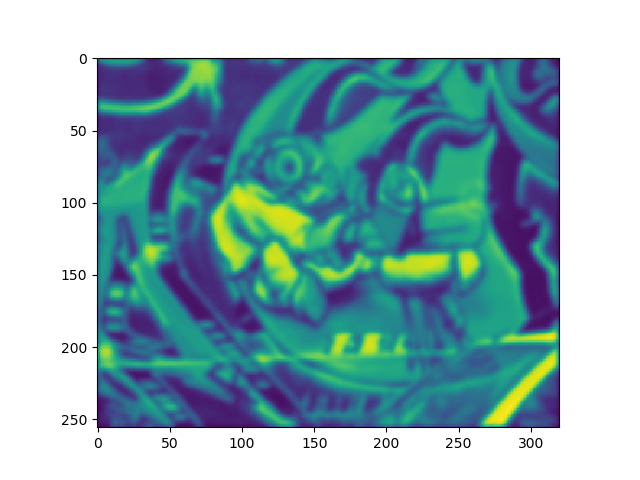

In [11]:
################################ TEST#############################################3

import imageio

image = imageio.imread('graf_small.png')

plt.figure()
plt.imshow(image[:,:,1])


s = 2
blurred_image = gaussian_filter(image,s)
plt.figure()
#plt.imshow(blurred_image)
plt.imshow(blurred_image[:,:,0])

Read the image ``graf_small.png`` and apply the filters with ``sigma = 2``, ``4``, and ``8``.
Again, choose the kernel size as $2 \cdot \lceil 3 \sigma\rceil + 1$.
What do you observe?

<IPython.core.display.Javascript object>


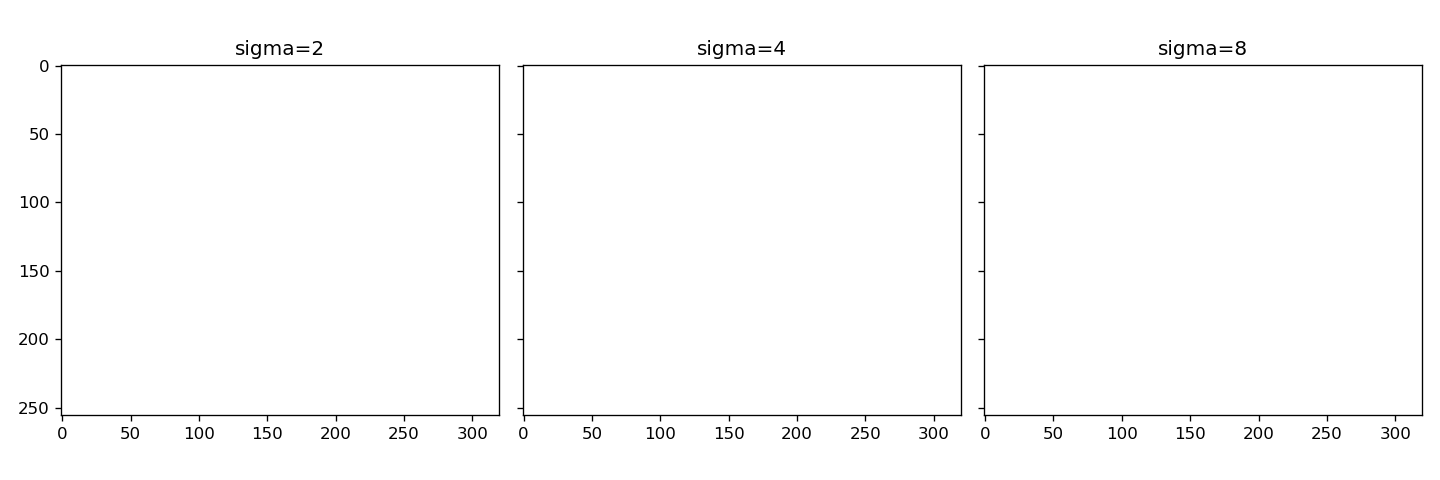

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [9]:
image = imageio.imread('graf_small.png')
sigmas = [2, 4, 8]
blurred_images = [gaussian_filter(image, s) for s in sigmas]
titles = [f'sigma={s}' for s in sigmas]

plot_multiple(blurred_images, titles)

OpenCV has many built-in function for image smoothing.
Check out this page:
https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html

Compare the result of ``cv2.GaussianBlur`` with your own implementation by computing the difference image.
Was your implementation correct?

<IPython.core.display.Javascript object>


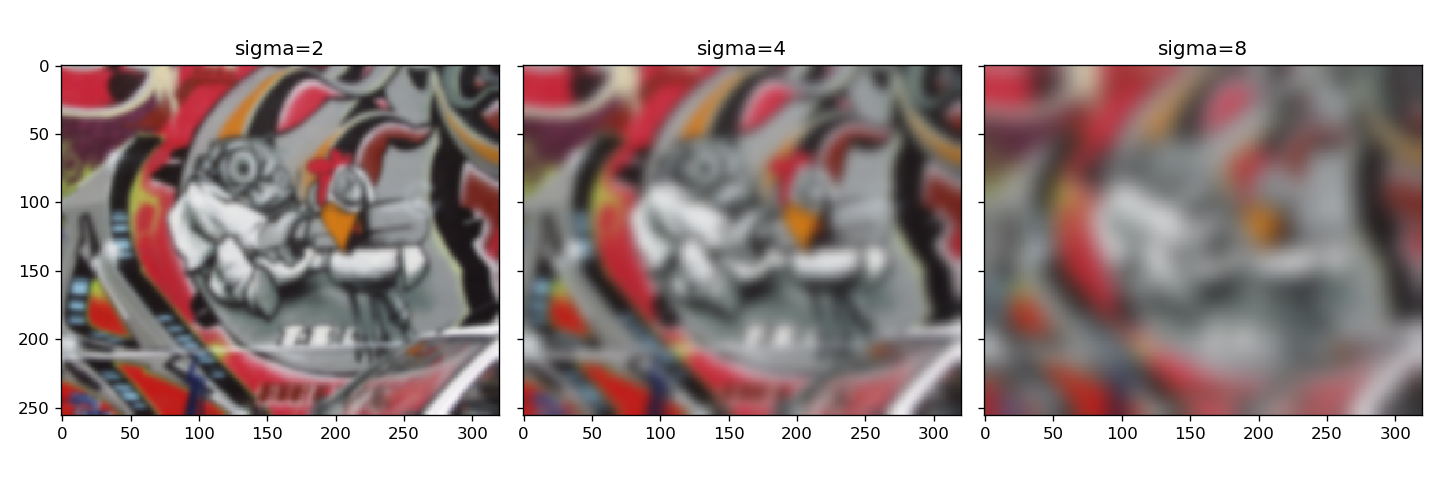

<IPython.core.display.Javascript object>


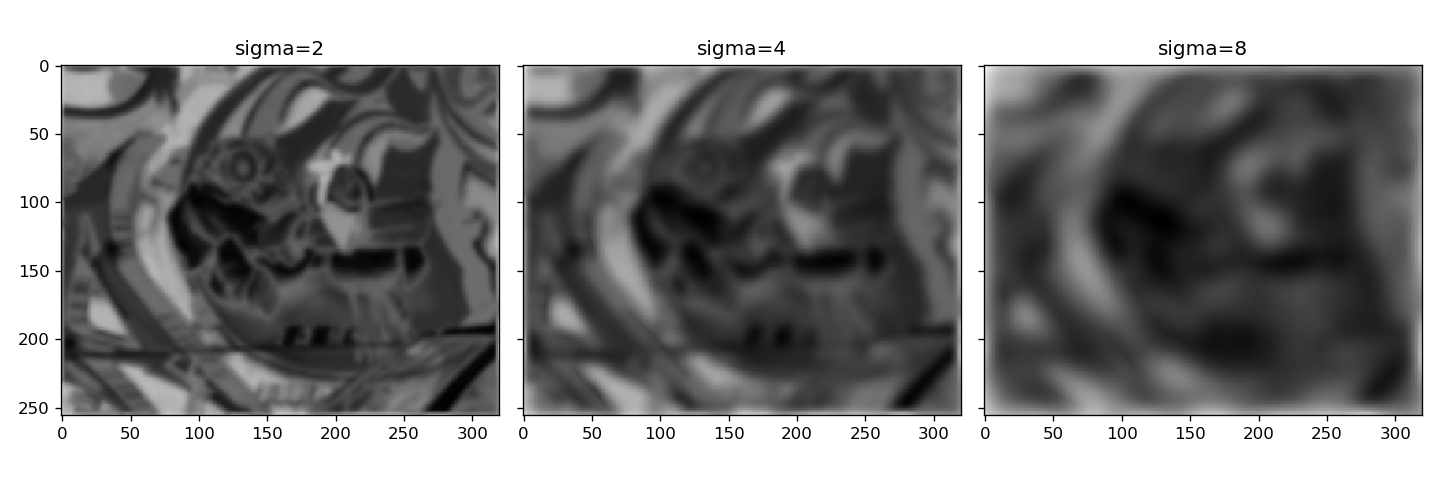

In [10]:
def gauss_cv(image, sigma):
    ks = 2 * int(np.ceil(3 * sigma)) + 1
    return cv2.GaussianBlur(image, (ks, ks), sigma, cv2.BORDER_DEFAULT)

def abs_diff(image1, image2):
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    return np.mean(np.abs(image1-image2), axis=-1)

blurred_images_cv = [gauss_cv(image, s) for s in sigmas]
differences = [abs_diff(x,y) for x, y in zip(blurred_images, blurred_images_cv)]

plot_multiple(blurred_images_cv, titles)
plot_multiple(differences, titles)

# Small differences (around 1-2) can be expected because of rounding
# Mouse over the difference image and see the value in the corner in square brackets

# Fourier transform

In this part, we look at the effect of filtering in Fourier space.
This gives us a different way of looking at images and yields deeper insights to what is going on when we apply a filter or downsample an image.

In [ ]:
# Some Convenience Functions.

def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1, mode='wrap')
    image = ndimage.convolve(image, kernel2, mode='wrap')
    return image

def fourier_spectrum(im):
    normalized_im = im / np.sum(im)
    f = np.fft.fft2(normalized_im)
    return np.fft.fftshift(f)

def log_magnitude_spectrum(im):
    return np.log(np.abs(fourier_spectrum(im))+1e-8)

def plot_with_spectra(images, titles):
    """Plots a list of images in the first column and the logarithm of their
    magnitude spectrum in the second column."""
    
    assert len(images) == len(titles)
    n_cols = 2
    n_rows = len(images)
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False)

    spectra = [log_magnitude_spectrum(im) for im in images]

    lower = min(np.percentile(s, 0.1) for s in spectra)
    upper = min(np.percentile(s, 99.999) for s in spectra)
    normalizer = mpl.colors.Normalize(vmin=lower, vmax=upper)
    
    for ax, image, spectrum, title in zip(axes, images, spectra, titles):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(title)
        ax[0].set_axis_off()
        c = ax[1].imshow(spectrum, norm=normalizer, cmap='viridis')
        ax[1].set_title('Log magnitude spectrum')
        ax[1].set_axis_off()
        
    fig.tight_layout()
    
def gauss(x, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(- x**2 / 2 / sigma**2)
    
def generate_pattern():
    x = np.linspace(0, 1, 256, endpoint=False)
    y = np.sin(x**2 * 16 * np.pi)
    return np.outer(y,y)/2+0.5

**Plotting demo:**
This is how you can load example images and plot the logarithm of its magnitude spectrum.
Low frequencies appear near the center and higher frequencies towards the outside.
Greener (lighter) colors mean higher values. The color scale is consistent within the subplots of a single plot, but may differ in different plots.

In [ ]:
im_grass = imread_gray('grass.jpg')
im_zebras = imread_gray('zebras.jpg')
im_pattern = generate_pattern()
plot_with_spectra([im_grass, im_zebras, im_pattern], ['Grass image', 'Zebra image', 'Pattern image'])

## Blurring

Consider one of the images (`im_grass` is a good choice). Implement `filter_box(image, size)` that outputs the box-filtered version of `image`, using `convolve_with_two` (since the box filter is separable). The parameter `size` refers to the side length of the box filter.

In [ ]:
# POINTS: 2

def filter_box(image, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

Implement `filter_gauss(image, kernel_factor, sigma)` using `convolve_with_two`. The parameter `kernel_factor` defines the half size of the kernel relative to sigma (our rule of thumb from the lecture was to set this as 3).

In [ ]:
# POINTS: 2

def filter_gauss(image, kernel_factor, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

Plot the image and its blurred versions (with the box and the Gauss filter) along with their spectra using `plot_with_spectra()`. Vary the size of the box filter. What do you observe? For the Gaussian, change sigma.  What happens if you increase or decrease the `kernel_factor` compared to our rule-of-thumb value 3?

In [ ]:
sigma = 3
im = im_grass
gauss_filtered = filter_gauss(im, kernel_factor=6, sigma=sigma)
box_filtered = filter_box(im, sigma=sigma)
plot_with_spectra(
    [im, box_filtered, gauss_filtered], 
    ['Image', 'Box filtered', 'Gauss filtered'])

## Sampling and aliasing

Implement a function `sample_with_gaps(image, period)`, where `period` is an integer and defines the distance between two sampled points in pixels. The output should have the same size as `image` but have zeros everywhere except at the sampled points, where it should be equal to `image`. For example if `period=2` then every second row and every second column of the image should be zero in the output.

In addition, implement `sample_without_gaps(image, period)`, which is like `sample_with_gaps` but the output does not contain gaps (rows and columns of zeros) and therefore the output size is smaller.

Hint: These two functions can easily be realized with [Numpy indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html). Do not use for-loop.

In [ ]:
# POINTS: 2

def sample_with_gaps(im, period):
    # YOUR CODE HERE
    raise NotImplementedError()

def sample_without_gaps(im, period):
    # YOUR CODE HERE
    raise NotImplementedError()

Sample the `im_zebras` image with a period of 2 pixels and plot the original and sampled images along with their spectra. 
What effect do you see in the resulting magnitude spectrum, when sampling with or without gaps?

In [ ]:
N=4
im = im_zebras
sampled_gaps = sample_with_gaps(im, N)
sampled = sample_without_gaps(im, N)

blurred = filter_gauss(im, kernel_factor=6, sigma=4)
blurred_and_sampled_gaps = sample_with_gaps(blurred, N)
blurred_and_sampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im, sampled_gaps, sampled, blurred, blurred_and_sampled_gaps, blurred_and_sampled], 
    ['Original', 'Sampled (w/ gaps)', 'Sampled', 'Gauss blurred', 'Blurred and s. (w/ gaps)', 'Blurred and s.'])

Consider the image `im_pattern` and sample it with a period of 4, 8 and 16 and plot the resulting spectra. What happens as you increase the sampling period?
Now look at what happens when **Gaussian blurring** is applied before sampling, with different sigma values. Approximately what sigma do you need for avoiding artifacts when `period=16`?

In [ ]:
N=16
image = im_pattern
downsampled_gaps = sample_with_gaps(im_pattern, N)
downsampled = sample_without_gaps(im_pattern, N)

blurred = filter_gauss(image, kernel_factor=6, sigma=12)
blurred_and_downsampled_gaps = sample_with_gaps(blurred, N)
blurred_and_downsampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im_pattern, downsampled_gaps, downsampled, blurred, blurred_and_downsampled_gaps, blurred_and_downsampled], 
    ['Original', 'Downsampled (w/ gaps)', 'Downsampled (no gaps)', 'Gauss blurred', 'Blurred and ds. (w/ gaps)', 'Blurred and downs. (no gaps)'])

# Image derivatives
This task introduces image derivative operators.

In [ ]:
# Some Convenience Functions.

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def imread_gray(filename):
    """Read grayscale image."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()
    
def gauss(x, sigma):
    return 1.0 / np.sqrt(2.0 * np.pi) / sigma * np.exp(- x**2 / 2.0 / sigma**2)

Implement a function for creating a Gaussian derivative filter in 1D according to the following equation
\begin{eqnarray}
    \frac{d}{dx} G &=& \frac{d}{dx} \frac{1}{\sqrt{2\pi}\sigma} \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr) \\
			       &=& -\frac{1}{\sqrt{2\pi}\sigma^3}x \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr)
\end{eqnarray}
Your function should take a vector of integer values $x$ and the standard deviation ``sigma`` as arguments.

In [ ]:
# POINTS: 1

def gaussdx(x, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
x = np.linspace(-5, 5, 100)
y = gaussdx(x, sigma=1.0)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

The effect of a filter can be studied by observing its so-called *impulse response*.
For this, create a test image in which only the central pixel has a non-zero value (called an *impulse*).

In [ ]:
# POINTS: 1

def make_impulse_image(size=25):
    # YOUR CODE HERE
    raise NotImplementedError()
    return impulse

What happens when you apply the following filter combinations on the impulse image?

- first ``gaussian``, then ``gaussian^T``.
- first ``gaussian``, then ``derivative^T``.
- first ``derivative``, then ``gaussian^T``.
- first ``gaussian^T``, then ``derivative``.
- first ``derivative^T``, then ``gaussian``.

Display the result images with the `plot_multiple` function. Describe your result.

In [ ]:
# create kernels
sigma = 6.0
kernel_radius = int(3.0 * sigma)
x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
G = gauss(x, sigma)
D = gaussdx(x, sigma)

impulse = make_impulse_image()
images = [
    impulse,
    convolve_with_two(impulse, G, G.T),
    convolve_with_two(impulse, G, D.T),
    convolve_with_two(impulse, D, G.T),
    convolve_with_two(impulse, G.T, D),
    convolve_with_two(impulse, D.T, G)]

titles = [
    'original',
    'first G, then G^T',
    'first G, then D^T',
    'first D, then G^T',
    'first G^T, then D',
    'first D^T, then G']

plot_multiple(images, titles, max_columns=3)

Create a new function ``gaussderiv`` using the functions ``gauss`` and ``gaussdx`` directly.
The new function should return the 2D Gaussian derivatives of an input image in $x$ and $y$ direction.
Try the function on the given example images.

In [ ]:
# POINTS: 2

def gauss_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    # YOUR CODE HERE
    raise NotImplementedError()
    return image_dx, image_dy

In [ ]:
image = imread_gray('tomatoes.png')
grad_dx, grad_dy = gauss_derivs(image, sigma=5.0)
plot_multiple([image, grad_dx, grad_dy], ['Image', 'Derivative in x-direction', 'Derivative in y-direction'])

In a similar manner, create a new function ``gauss_second_derivs`` that returns the 2D second Gaussian derivatives $\frac{d^2}{dx^2}$, $\frac{d^2}{dx dy}$ and $\frac{d^2}{dy^2}$ of an input image.
Try the function on the given example images.

In [ ]:
# POINTS: 2

def gauss_second_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return image_dxx, image_dxy, image_dyy

In [ ]:
image = imread_gray('coins1.jpg')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ['Image', 'Dxx', 'Dxy','Dyy'])

In [ ]:
image = imread_gray('circuit.png')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ['Image', 'Dxx', 'Dxy','Dyy'])

Create a new function ``image_gradients_polar`` that returns two images with the magnitude and orientation of the gradient for each pixel of the input image. Try the function on the given example images.

In [ ]:
# POINTS: 2

def image_gradients_polar(image, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()
    return magnitude, direction

In [ ]:
image = imread_gray('coins1.jpg')
grad_mag, grad_dir = image_gradients_polar(image, sigma=2.0)

# Note: the twilight colormap only works since Matplotlib 3.0, use 'gray' in earlier versions.
plot_multiple([image, grad_mag, grad_dir], ['Image', 'Magnitude', 'Direction'], colormap=['gray', 'gray', 'twilight']) 

In [ ]:
image = imread_gray('circuit.png')
grad_mag, grad_theta = image_gradients_polar(image, sigma=2.0)
plot_multiple([image, grad_mag, grad_theta], ['Image', 'Magnitude', 'Direction'], colormap=['gray', 'gray', 'twilight'])

Create a new function ``laplace`` that returns an image with the Laplacian-of-Gaussian for each pixel of the input image.
Try the function on the given example images

In [ ]:
# POINTS: 2

def laplace(image, sigma):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
image = imread_gray('coins1.jpg')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

In [ ]:
image = imread_gray('circuit.png')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

# Edge detection
In this part we will create a simple edge detector. 

**Note:** you will need `gauss_derivs` and `image_gradients_polar` functions from the task "Image derivatives". 

In [ ]:
# Some convenience functions.

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, imsize=4, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imsize, n_rows * imsize),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

Write a function ``get_edges`` that returns a binary image ``edge`` from an input image where the color of each pixel $p$ is selected as follows (for a given threshold ``theta``):
\begin{eqnarray}
    p &=&
    \begin{cases}
        1, &\text{ if }\left|\operatorname{grad}(\mathtt{img})\right|(p) \geq \theta\\
        0, &\text{ else}
    \end{cases}
\end{eqnarray}
Experiment with the function ``get_edges`` on the example images.
Try to get good edge images for different values of ``sigma``.
What difficulties do you observe when selecting ``sigma`` and ``theta``?

In [ ]:
# POINTS: 1

def get_edges(image, sigma, theta):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY).astype(np.float32)
plot_multiple([gray_im], ['Image'])

sigmas = [1, 2]
thetas = [1, 2, 5, 10, 20, 40, 60]

images = []
titles = []
for sigma in sigmas:
    for theta in thetas:
        edges = get_edges(gray_im, sigma, theta)    
        images.append(edges)
        titles.append(f'sigma={sigma}, theta={theta}')

plot_multiple(images, titles, max_columns=7, imsize=2)

Using the above function, returned edges are still several pixels wide.
In practice, this is often not desired.
Create a function ``get_edges_with_nms`` that extends ``get_edges`` by using the following function to suppress non-maximum points along the gradient direction.

Note that this simplified code does not interpolate between the neighboring pixel values in order to look up the real magnitude samples along the gradient direction.
This interpolation is crucial to obtain the necessary robustness for an actual implementation.
Here it was left out for better readability, since the interpolation involves some extra effort in order to deal with all special cases (e.g. exactly horizontal or vertical gradients).
If you feel motivated, you can try to add this step to make the function more robust.

In [ ]:
# POINTS: 4

def nms_for_canny(grad_mag, grad_dir):
    result = np.zeros_like(grad_mag)
        
    # Pre-define pixel index offset along different orientation
    offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1, -1]
    offsets_y = [0, -1, -1, -1, 0, 1, 1, 1, 0]
    height, width = grad_mag.shape
    for y in range(1, height-1):
        for x in range(1, width-1):
            
            # YOUR CODE HERE
            raise NotImplementedError()
    
    return result

Another problem is that suitable values for ``theta`` may vary substantially between images.
Extend the function ``get_edges_with_nms`` such that the threshold $\theta \in [0,1]$ is defined relative to the maximal gradient magnitude value in the image.

In [ ]:
# POINTS: 1

def get_edges_with_nms(image, sigma, theta):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
edges1 = get_edges(gray_im, sigma=2, theta=5)
edges2 = get_edges_with_nms(gray_im, sigma=2, theta=0.17) # 0.17 corresponds to an absolute threshold of 5

plot_multiple([edges1, edges2], ['get_edges', 'get_edges_with_nms'], imsize=6)

The function ``get_edges`` you implemented is a simplified version of the Canny edge detection pipeline.
The main step that is still missing is the edge following with hysteresis thresholding.
The idea here is that instead of applying a single threshold over the entire image, the edge detector works with two different thresholds ``theta_high`` and ``theta_low``.
It starts with an edge pixel with a value above ``theta_high`` and then follows the contour in the direction orthogonal to the gradient until the pixel value falls below ``theta_low``.
Each pixel visited along the way is labeled as an edge.
The procedure is repeated until no further pixel above ``theta_high`` remains.

Try writing a function ``my_canny`` that implements this procedure.
Don't worry about efficiency for the moment.
You may use the provided function skeleton to help you get started but can also start from scratch. The following hints may help you:
- You can create a boolean array ``visited`` for already visited and yet-to-visit image pixels. Since we are not interested in pixels below the low threshold you can mark them as visited. In another boolean array you can flag the pixels that serve as starting points for line following.
- You can also avoid having to deal with special cases along the image borders by creating a 1-pixel boundary where the ``visited`` flag is set to ``true``.
- The actual edge following part is most easily implemented as a recursive procedure. In most cases, you will have the option to choose between several possible continuation points. Again, the easiest way is to try all of them in sequence (or even all 8 neighbors) and let the recursive procedure (together with the ``visited`` flags) do the rest.

In [ ]:
# POINTS: 5

def my_canny(image, sigma, theta_low, theta_high):
    # Compute gradient, apply non-maximum suppression
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # Compute absolute threshold relative to max value
    max_val = np.max(grad_mag)
    theta_low_abs = theta_low * max_val
    theta_high_abs = theta_high * max_val
    
    # Initialize flags
    # Declare all pixels below the low threshold as visited
    # so edges are not followed there
    visited = grad_mag < theta_low_abs  
    
    # Mark boundary pixels as visited
    visited[:, 0] = 1
    visited[:, -1] = 1
    visited[0, :] = 1
    visited[-1, :] = 1
 
    # Output image
    image_out = np.zeros_like(image)
    
    def follow_edge(x, y):
        visited[y, x] = True
        image_out[y, x] = 255
        
        # Pre-define pixel index offset along different orientation
        offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1]
        offsets_y = [0, -1, -1, -1, 0, 1, 1, 1]           
    
        for ox, oy in zip(offsets_x, offsets_y):
            # Note: `visited` is already False for points
            # below the low threshold.
            
            # YOUR CODE HERE
            raise NotImplementedError()
            

    is_high = grad_mag >= theta_high_abs
    # Main loop
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # YOUR CODE HERE
            raise NotImplementedError()
                
    return image_out                

OpenCV provides a built-in function that implements the Canny edge detector.
https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
Try ``cv2.Canny`` on the provided example images and compare the results to those of your implementation.
Note: the implementation of ``cv2.Canny`` does not include blurring the image as we did.
So apply ``cv2.GaussianBlur`` on the image, before passing it to ``cv2.Canny``.

In [ ]:
edge_canny = my_canny(gray_im, sigma=2, theta_low=0.1, theta_high=0.3)

blurred_cv = cv2.GaussianBlur(gray_im, ksize=(7,7), sigmaX=2)
edge_canny_cv = cv2.Canny(
    blurred_cv.astype(np.uint8), 
    39, 72, L2gradient=True).astype(np.float32)

plot_multiple([edge_canny, edge_canny_cv, edge_canny-edge_canny_cv], 
              ['my_canny', 'cv2.Canny', 'Difference'], imsize=5)

## [OPTIONAL] Improved edge detector
This solution gives better results, but its results still depend strongly on the maximal gradient magnitude value in the image.
For a cleaner solution, we want to adapt the threshold to the distribution of all gradient magnitude values, such that we can directly control the number of edge pixels we get.
Extend the function `get_edges` by the following steps in order to do this:

- Perform non-maximum suppression on the gradient magnitude image as shown above.
- Transform the result image into a vector.
- Build a histogram of the remaining gradient magnitude values.
- Compute the cumulative sum over the histogram (except for the first cell).
- The last cell of the cumulative histogram now contains the total number of edge pixels in the image, `num_total_edge_pixels`. Compute the desired number of edge pixels `num_desired_edge_pixels` as the percentage `theta` of `num_total_edge_pixels`.
- Find the threshold for which the cumulative histogram contains the value `num_desired_edge_pixels`.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Hough transform

In this task, we will implement a Hough transform in order to detect parametric curves, such as lines or circles.
In the following, we shortly review the motivation for this technique.

Consider the point $p=(\mathtt{x},\mathtt{y})$ and the equation for a line $y = mx+c$. What are the lines that could pass through $p$?
The answer is simple: all the lines for which $m$ and $c$ satisfy $\mathtt{y} = m\mathtt{x}+c$.
Regarding $(\mathtt{x},\mathtt{y})$ as fixed, the last equation is that of a line in $(m,c)$-space.
Repeating this reasoning, a second point $p'=(\mathtt{x}',\mathtt{y}')$ will also have an associated line in parameter space, and the two lines will intersect at the point $(\tilde{m},\tilde{c})$, which corresponds to the line connecting $p$ and $p'$.

In order to find lines in the input image, we can thus pursue the following approach.
We start with an empty accumulator array quantizing the parameter space for $m$ and $c$.
For each edge pixel in the input image, we then draw a line in the accumulator array and increment the corresponding cells.
Edge pixels on the same line in the input image will produce intersecting lines in $(m,c)$-space and will thus reinforce the intersection point.
Maxima in this array thus correspond to lines in the input image that many edge pixels agree on.

In practice, the parametrization in terms of $m$ and $c$ is problematic, since the slope $m$ may become infinite.
Instead, we use the following parametrization in polar coordinates:
\begin{equation}
	\mathtt{x}\cos\theta + \mathtt{y}\sin\theta = \rho \label{eq:hough_line}
\end{equation}
This produces a sinusoidal curve in $(\rho,\theta)$-space, but otherwise the procedure is unchanged.

The following sub-questions will guide you through the steps of building a Hough transform.

## Hough voting
Build up an accumulator array ``acc`` for the parameter space $(\rho, \theta)$. $\theta$ ranges from $-\pi/2$ to $\pi/2$, and $\rho$ ranges from $-D$ to $D$, where $D$ denotes the length of the image diagonal.
Use ``n_bins_rho`` and ``n_bins_theta`` as the number of bins in each direction.
Initially, the array should be filled with zeros.

For each edge pixel in the input image, create the corresponding curve in $(\rho, \theta)$ space by evaluating above line equation for all values of $\theta$ and incrementing the corresponding cells of the accumulator array.

In [ ]:
# POINTS: 5

def hough_transform(edge_image, n_bins_rho, n_bins_theta):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, n_bins_theta), dtype=np.int)  
    
    # Create bins
    diag = np.linalg.norm(edge_image.shape)  # Length of image diagonal
    theta_bins = np.linspace(-np.pi / 2, np.pi / 2, n_bins_theta)
    rho_bins = np.linspace(-diag, diag, n_bins_rho)
    
    # YOUR CODE HERE
    raise NotImplementedError()
    return votes, rho_bins, theta_bins

Now we can test the implementation on an example image and visualize the resulting Hough space by displaying it as a 2D image.

In [ ]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY)

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

hough_space, rho_bins, theta_bins = hough_transform(edges, n_bins_rho=300, n_bins_theta=300)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(color_im)
axes[0].set_title('Image')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges')
axes[2].imshow(hough_space)
axes[2].set_title('Hough space')
axes[2].set_xlabel('theta (index)')
axes[2].set_ylabel('rho (index)')
fig.tight_layout()

## Non-maximum suppression and finding peaks
Write a function ``nms2d`` which suppresses all points in the Hough space that are not local maxima.
This can be achieved by looking at the 8 direct neighbors of each pixel and keeping only pixels whose value is greater than all its neighbors. This function is simpler than the non-maximum suppression from the Canny Edge Detector exercise, since it does not take into account local gradients.

Tip: think about what to do at the borders of the Hough array. What happens if we simply ignore the border areas? How should we treat it to be precise? (Remember that theta represents an angle that wraps around back to itself).

In [ ]:
# POINTS: 3

def nms2d(hough_array):
    hough_array_out = np.zeros_like(hough_array)
    
    # YOUR CODE HERE
    raise NotImplementedError()
                
    return hough_array_out

Write a function ``find_hough_peaks`` that takes the result of ``hough_transform`` as an argument, finds the extrema in Hough space using ``nms2d`` and returns the index of all points $(\rho_i, \theta_i)$ for which the corresponding Hough value is greater than ``threshold``. What would happen if we swapped the order of the thresholding and the NMS operations?

In [ ]:
# POINTS: 1

def find_hough_peaks(hough_space, threshold):
    # YOUR CODE HERE
    raise NotImplementedError()

Now, let's plot the results of your implementation. Are the results correct? Are there any undetected lines or wrong lines returned? If yes, why are those lines missing and why are there false positives? Can you think of ways to avoid those mistakes?

In [ ]:
def plot_hough_lines(image, rho, theta):
    # compute start and ending point of the line x*cos(theta)+y*sin(theta)=rho
    x0, x1 = 0, image.shape[1] - 1
    y0 = rho / np.sin(theta)
    y1 = (rho - x1 * np.cos(theta)) / np.sin(theta)

    # Check out this page for more drawing function in OpenCV:
    # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    for yy0, yy1 in zip(y0, y1):
        cv2.line(image, (x0, int(yy0)), (x1, int(yy1)), color=(255, 0, 0), thickness=1)

    return image

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 200)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imageio.imread('gantrycrane.png')
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

In [ ]:
# Try another image
im = imageio.imread('circuit.png')

blurred = cv2.GaussianBlur(im, None, sigmaX=2)
edge = cv2.Canny(blurred, threshold1=30, threshold2=90)
hough_space, rho_bins, theta_bins = hough_transform(edge, n_bins_rho=300, n_bins_theta=300)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 100)
print(f'circuit.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]
color_image = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)
fig.tight_layout()

## [OPTIONAL] Circle Hough transform for circles

The Hough transform is a general technique that can not only be applied to lines, but also to other parametric curves, such as circles.
In the following, we will show how the implementation can be extended to finding circles.

A circle can be parameterized by the following equation:
$$	
    (\mathtt{x}-a)^2 + (\mathtt{y}-b)^2 = r^2. \label{eq:hough_circle}
$$

Unfortunately, the computation and memory requirements for the Hough transform increase exponentially with the number of parameters.
While a 3D search space is still just feasible, we can dramatically reduce the amount of computation by integrating the gradient direction in the algorithm.

Without gradient information, all values $a, b$ lying on the cone given by above equation are incremented.
With the gradient information, we only need to increment points on an arc centered at $(a, b)$:
\begin{eqnarray}
	a &=& x + r\cos\phi\\
	b &=& y + r\sin\phi,
\end{eqnarray}
where $\phi$ is the gradient angle returned by the edge operator.

Create a function ``hough_circle`` which implements the Hough transform for circles.
Try your implementation for a practical application of counting coins in an image.
You can use the images ``coins1.png`` and ``coins2.png`` for testing.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## [OPTIONAL] Line Hough transform with gradient information 
The same trick of using the image gradient can be used for lines.
Modify the hough voting code to only vote for one line per edge pixel, instead of all the lines running through this pixel.
Can you think of any disadvantages of this approach?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## [OPTIONAL] Counting coins

Can you build a demo application that takes a photo of several different Euro coins lying on a table as input and tells you how much money it is in total in Euros (i.e. the output is one number)?

How well does it work when the coins start to overlap or lie on top of each other?

Use the functions you wrote in the previous questions.
(Hint: you may need to include a reference shape in the picture in order to obtain the absolute scale, i. e. to convert from pixels to millimeters).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()